1st Step: Setup and load data

In [ ]:
#Install windows/linux dependencies
%pip install tensorflow tensorflow-gpu opencv-python matplotlib


In [ ]:
#Installing MAC-OS dependencies Enabling usage of GPU on MAC

%pip install tensorflow-macos
%pip install tensorflow-metal


In [122]:
import tensorflow as tf
import cv2
import matplotlib
from matplotlib import pyplot as plt
import os

print("TensorFlow version:", tf.__version__)
print("OpenCV version:", cv2.__version__)
print("Matplotlib version:", matplotlib.__version__)


TensorFlow version: 2.16.2
OpenCV version: 4.11.0
Matplotlib version: 3.10.3


In [123]:
#Verify tensorflow versions

%pip list | grep tensorflow


tensorflow                   2.16.2
tensorflow-io-gcs-filesystem 0.37.1
tensorflow-macos             2.16.2
tensorflow-metal             1.2.0
Note: you may need to restart the kernel to use updated packages.


In [136]:
# Enable dynamic GPU memory allocation to avoid Out Of Memory (OOM) errors.
# This allows TensorFlow to allocate memory on the GPU as needed, instead of pre-allocating all available memory.

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
# List detected GPU devices (if any)
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
#Downloading the data sets

%pip install kagglehub

In [ ]:
# ────────────────────────────────────────────────────────────────────────────────
# DOWNLOAD AND ORGANIZE THE DATASET (Run once if not cloned with the project)
# This block downloads the FER2013 dataset via KaggleHub and moves it to your project directory.
# Only needed the first time you prepare your local environment.
# ────────────────────────────────────────────────────────────────────────────────

import kagglehub
import shutil


# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

# Define source and destination paths
src = "/Users/aymenoumali/.cache/kagglehub/datasets/msambare/fer2013/versions/1"
dst = "/Users/aymenoumali/Documents/Internship/CNN/data"

# Create destination folder if it doesn't exist
os.makedirs(dst, exist_ok=True)

# Move the entire content (recursively)
for item in os.listdir(src):
    s = os.path.join(src, item)
    d = os.path.join(dst, item)
    shutil.move(s, d)

print("Dataset moved to:", dst)

shutil.rmtree(src)
print("Original dataset cache deleted.")

In [ ]:
import cv2
import imghdr

data_dir = os.path.join('data', 'train')
image_class = os.listdir(data_dir)

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        print(image) #as a np array


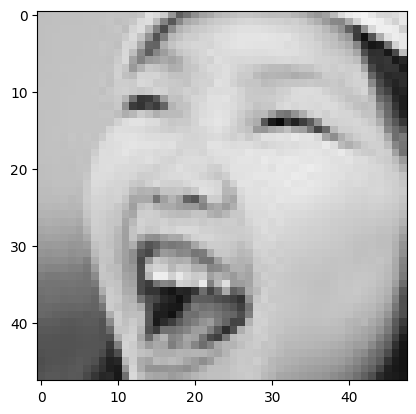

In [126]:
#Example of an image

img = cv2.imread(os.path.join(data_dir, 'happy/Training_50580.jpg'))
plt.imshow(img)

In [ ]:
import numpy as np
from matplotlib import pyplot as pyplot

# Load the training dataset from directory and convert it to a NumPy iterator.
# This allows manual inspection of a batch of images (batch[0]) and their corresponding labels (batch[1]),
# where each label is an integer automatically mapped from the subdirectory name.

data = tf.keras.utils.image_dataset_from_directory(os.path.join('data', 'train'))
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

#Images represented as np arrays
batch[0].shape

#classes names are associated to numbers
batch[1]

Found 28709 files belonging to 7 classes.


array([3, 6, 2, 4, 3, 2, 3, 3, 6, 5, 4, 5, 5, 5, 0, 3, 5, 5, 2, 3, 2, 4,
       6, 4, 6, 3, 4, 2, 4, 6, 3, 2], dtype=int32)

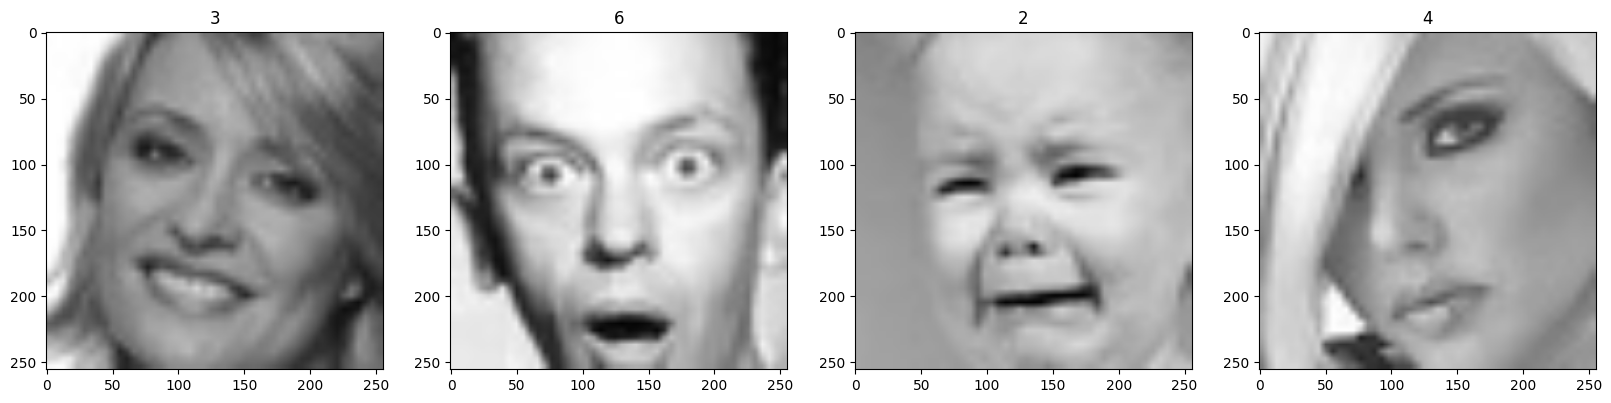

In [128]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx]. title.set_text(batch[1][idx])

#class 0 = angry ppl
#class 1 = disgust
#class 2 = fear
#class 3 = happy
#class 4 = neutral
#class 5 = sad
#class 6 = surprise

2nd Step: Process data

In [ ]:
# Load the training dataset from directory with the correct image configuration.
# Each image is resized to 48x48 pixels and loaded in grayscale (1 channel).
# The dataset is batched (32 samples per batch), shuffled, and labels are returned as integer indices.
# We then normalize the image pixel values to the [0, 1] range using a map() transformation,
# and create a NumPy iterator to manually inspect the processed batches if needed.

img_size = (48, 48)

data = tf.keras.utils.image_dataset_from_directory(
    os.path.join('data', 'train'),
    image_size=img_size,
    color_mode='grayscale',
    batch_size=32,
    label_mode='int',
    shuffle=True
)

data = data.map(lambda x, y: (x / 255.0, y))

scaled_iterator = data.as_numpy_iterator()

Found 28709 files belonging to 7 classes.


In [130]:
scaled_iterator.next()[0].max()

1.0

In [131]:
scaled_iterator.next()[0].min()

0.0

In [138]:
# The original dataset only includes a training and a test set.
# To evaluate model performance during training, we manually split the training set into two subsets:
# 80% for actual training and 20% for validation, which helps monitor overfitting and generalization.

train_size = int(len(data)*0.8)
val_size = int(len(data)*0.2)

In [139]:
# Split the preprocessed training dataset into two parts:
# - `train`: the first 80% of the data for model training
# - `val`: the remaining 20% for validation during training
# Then, load the separate test dataset from the 'data/test' directory, applying the same preprocessing steps:
# resizing to 48x48, grayscale conversion, normalization, and batching.
# Shuffling is disabled for test data to preserve order during evaluation.

train = data.take(train_size)
val = data.skip(train_size).take(val_size)

test = tf.keras.utils.image_dataset_from_directory(
    os.path.join('data', 'test'),
    image_size=img_size,
    color_mode='grayscale',
    batch_size=32,
    label_mode='int',
    shuffle=False
)

test = test.map(lambda x, y: (x / 255.0, y))

print(len(train), len(val), len(test))


Found 7178 files belonging to 7 classes.
718 179 225


3rd Step: Building the model

In [134]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras import Input


In [145]:
# ─────────────────────────────────────────────────────────────────────────────
# MODEL DEFINITION — CONVOLUTIONAL NEURAL NETWORK FOR EMOTION CLASSIFICATION
# This CNN processes grayscale images of size 48x48 to classify emotions into 7 classes.
# It consists of multiple convolutional blocks with batch normalization, max pooling,
# and dropout for regularization, followed by dense layers for final classification.
# ─────────────────────────────────────────────────────────────────────────────

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense

model = Sequential()

# Input layer — expects images of shape 48x48 with 1 channel (grayscale)
model.add(Input(shape=(48, 48, 1)))

# ────── Convolutional Block 1 ──────
# Conv2D: 16 filters of size 3x3, stride = 1, ReLU activation
# Purpose: Detect basic spatial patterns (edges, corners) in the input
model.add(Conv2D(16, (3, 3), strides=1, activation='relu'))

# BatchNormalization: Normalizes activations and gradients; helps stabilize and speed up training
model.add(BatchNormalization())

# MaxPooling2D: Reduces spatial dimensions (downsampling), keeping the most important features
model.add(MaxPooling2D())

# Dropout(0.25): Randomly disables 25% of neurons during training to reduce overfitting
model.add(Dropout(0.25))

# ────── Convolutional Block 2 ──────
# Conv2D: 32 filters (deeper features), same kernel size and activation
# Learns more abstract and complex features
model.add(Conv2D(32, (3, 3), strides=1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.25))

# ────── Convolutional Block 3 ──────
# Conv2D: Back to 16 filters (may act as refinement or dimensionality compression)
model.add(Conv2D(16, (3, 3), strides=1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.25))

# ────── Flattening ──────
# Flatten: Converts 3D feature maps to 1D feature vector to feed into dense layers
model.add(Flatten())

# ────── Fully Connected Layers ──────
# Dense: 256 neurons, ReLU activation
# Learns high-level combinations of features for classification
model.add(Dense(256, activation='relu'))

# BatchNormalization: Again used to stabilize and regularize dense layers
model.add(BatchNormalization())

# Dropout(0.5): Higher dropout rate here due to dense layer's large capacity
model.add(Dropout(0.5))

# ────── Output Layer ──────
# Dense: 7 output neurons (one per emotion class), softmax activation for probability distribution
model.add(Dense(7, activation='softmax'))

# ────── Model Compilation ──────
# - Optimizer: Adam — adaptive learning rate for faster convergence
# - Loss: sparse_categorical_crossentropy — used when labels are integers (not one-hot encoded)
# - Metric: sparse_categorical_accuracy — measures accuracy for integer-labeled multi-class problems
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)


In [143]:
# Display a layer-by-layer summary of the model architecture.
# This includes:
# - Layer type (Conv2D, MaxPooling2D, Dense, etc.)
# - Output shape after each layer (batch size is shown as `None`)
# - Number of trainable parameters (weights and biases)
#
# Interpretation:
# • The model starts with a series of convolutional blocks (Conv2D + BatchNorm + MaxPooling + Dropout)
#   that progressively reduce the spatial dimensions from 48x48 to 4x4, while learning deeper features.
# • The Flatten layer reshapes the 4x4x16 output into a 1D vector (256 units) for the dense layers.
# • The fully connected block includes a Dense(256) layer for feature combination,
#   followed by BatchNorm, Dropout, and finally a Dense(7) output layer with softmax activation.
#
# Total parameters: 78,295
# - Trainable: 77,655 → updated during training
# - Non-trainable: 640 → mainly from BatchNormalization layers (running mean & variance)


model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 46, 46, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 46, 46, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 23, 23, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 23, 23, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 21, 21, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 21, 21, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 16)       │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 8, 8, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,295 (305.84 KB)

 Trainable params: 77,655 (303.34 KB)

 Non-trainable params: 640 (2.50 KB)

In [ ]:
# Train the CNN model using the training and validation datasets.
# We use three callbacks to improve training monitoring and performance:
# - EarlyStopping: Stops training if validation loss doesn't improve after 3 epochs, preventing overfitting.
#   It also restores the best weights encountered during training.
# - ModelCheckpoint: Saves the model only when the validation loss improves, ensuring the best version is preserved.
# - TensorBoard: Logs training metrics (loss, accuracy) to the 'logs/' directory for interactive visualization.
# The model is trained for up to 20 epochs with these callbacks applied, using 'val' for validation performance tracking.

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

logdir = "logs"
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint(
    'best_model.keras',
    save_best_only=True,
    monitor='val_loss'
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist = model.fit(
    train,
    epochs=20,
    validation_data=val,
    callbacks=[tensorboard_callback, early_stop, checkpoint]
)


Epoch 1/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - loss: 2.4170 - sparse_categorical_accuracy: 0.2142 - val_loss: 1.6706 - val_sparse_categorical_accuracy: 0.3471
Epoch 2/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - loss: 1.7138 - sparse_categorical_accuracy: 0.3309 - val_loss: 1.5789 - val_sparse_categorical_accuracy: 0.3872
Epoch 3/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - loss: 1.5891 - sparse_categorical_accuracy: 0.3792 - val_loss: 1.5531 - val_sparse_categorical_accuracy: 0.3829
Epoch 4/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - loss: 1.5317 - sparse_categorical_accuracy: 0.4096 - val_loss: 1.4192 - val_sparse_categorical_accuracy: 0.4574
Epoch 5/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - loss: 1.4835 - sparse_categorical_accuracy: 0.4291 - val_loss: 1.3917 - val_sparse_categorical_accuracy: 0.4752
Epoch 6/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - loss: 1.4593 - sparse_categorical_accuracy: 0.4358 - val_loss: 1.3609 - val_sparse_categorical_accuracy:

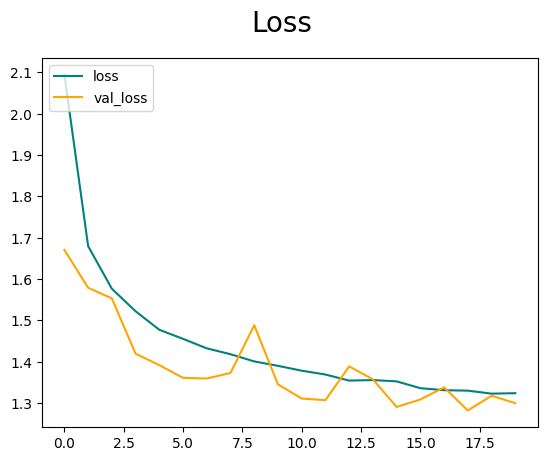

In [146]:
# Plot the training and validation loss curves to evaluate model performance over epochs.
# - The 'loss' curve shows how the model fits the training data.
# - The 'val_loss' curve shows how well the model generalizes to unseen validation data.
# 
# Interpretation:
# - Both curves decreasing smoothly is a sign of proper learning.
# - A small gap between them suggests good generalization and low overfitting.
# - If 'val_loss' starts increasing while 'loss' decreases, that’s a sign of overfitting.
# In this case, the validation loss follows the training loss quite closely, which is a healthy behavior.

fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
plt.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()


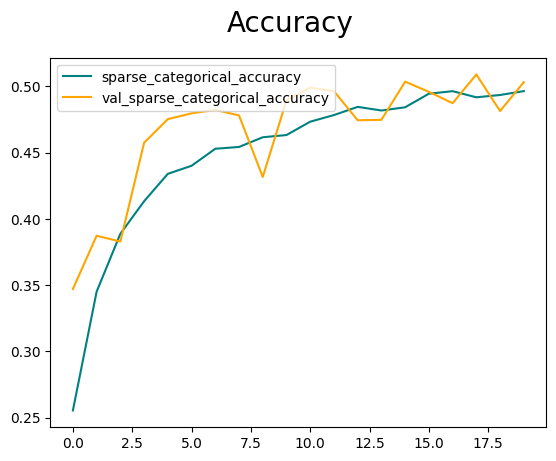

In [147]:
# Plot training and validation accuracy over epochs to monitor learning progress.
# - 'sparse_categorical_accuracy' tracks accuracy on training data.
# - 'val_sparse_categorical_accuracy' tracks how well the model performs on unseen validation data.
#
# Interpretation:
# - An increasing trend for both curves indicates that the model is learning useful patterns.
# - A small, stable gap between the two curves shows good generalization.
# - If validation accuracy stagnates or drops while training accuracy continues to improve,
#   that would suggest overfitting.
# In this case, both curves improve steadily and remain close — indicating stable and effective learning.

fig = plt.figure()
plt.plot(hist.history['sparse_categorical_accuracy'], color='teal', label='sparse_categorical_accuracy')
plt.plot(hist.history['val_sparse_categorical_accuracy'], color='orange', label='val_sparse_categorical_accuracy')
plt.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()


4th Step: Validate Model

In [ ]:
# Evaluate the model on the test dataset using precision, recall, and accuracy metrics.
# For each batch in the test set:
# - We generate predictions using the trained model (yhat).
# - Convert softmax outputs to class predictions via argmax.
# - Update the running metrics using the true labels (y) and predictions (yhat_classes).
#
# Metrics:
# - Precision: How many of the predicted positives are correct? (low false positives)
# - Recall: How many of the actual positives were detected? (low false negatives)
# - SparseCategoricalAccuracy: Overall proportion of correctly predicted labels (top-1 accuracy).
#
# Interpretation:
# - A high precision and recall with low accuracy likely indicate class imbalance:
#   the model is performing well on one or more classes, but missing others.
#   Consider analyzing the confusion matrix or per-class performance for deeper insights.

from tensorflow.keras.metrics import Precision, Recall, SparseCategoricalAccuracy

precision = Precision()
recall = Recall()
accuracy = SparseCategoricalAccuracy()

for X, y in test:
    yhat = model.predict(X)                     # shape: (batch_size, 7)
    yhat_classes = tf.argmax(yhat, axis=1)      # shape: (batch_size,)

    precision.update_state(y, yhat_classes)
    recall.update_state(y, yhat_classes)
    accuracy.update_state(y, yhat)

print(f"Precision: {precision.result().numpy():.4f}")
print(f"Recall:    {recall.result().numpy():.4f}")
print(f"Accuracy:  {accuracy.result().numpy():.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━

2025-06-01 14:13:27.261398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


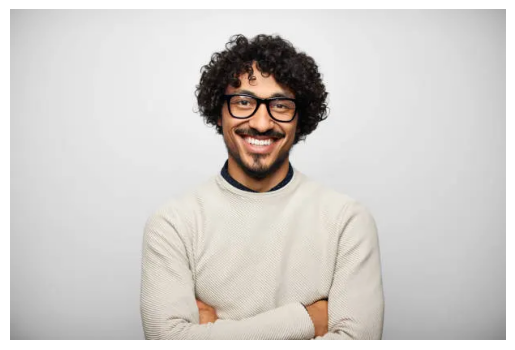

In [157]:
# Load and display a random external image (for manual testing of the model).
# - The image is read using OpenCV (which loads in BGR format by default).
# - It is then converted to RGB so it displays correctly with matplotlib.
# - This step helps visually confirm what image is being fed into the model.

img = cv2.imread(os.path.join('data', 'random', 'happytest.jpg'))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

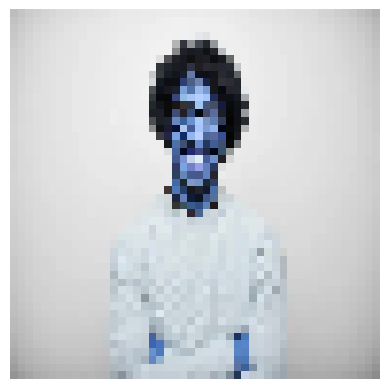

In [158]:
img_resized = cv2.resize(img, (48, 48))
img_normalized = img_resized.astype('float32') / 255.0
img_input = np.expand_dims(img_normalized, axis=(0, -1))
img_input = tf.convert_to_tensor(img_input, dtype=tf.float32)   # make sure it's a tensor


plt.imshow(np.squeeze(img_input), cmap='gray')
plt.axis('off')
plt.show()


In [159]:
# Preprocess and predict the emotion of a custom image using the trained model.
# Steps:
# 1. Load the image in grayscale to match the training data format.
# 2. Resize it to 48x48 pixels (same as model input size).
# 3. Normalize pixel values to [0, 1] and reshape to (1, 48, 48, 1) to simulate a batch.
# 4. Convert to a TensorFlow tensor for compatibility with the model.
# 5. Perform prediction with the trained model.
# 6. Use argmax to obtain the predicted class index, and map it to the corresponding emotion label.

img_path = os.path.join("data", "random", "sadtest.jpg")
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

img_resized = cv2.resize(img, (48, 48))
img_normalized = img_resized.astype('float32') / 255.0
img_input = np.expand_dims(img_normalized, axis=(0, -1))  # shape: (1, 48, 48, 1)
img_input = tf.convert_to_tensor(img_input, dtype=tf.float32)

print("img_input shape:", img_input.shape)

yhat = model.predict(img_input)
predicted_class = tf.argmax(yhat, axis=1).numpy()[0]

class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
print("Predicted class index:", predicted_class)
print("Predicted label:", class_names[predicted_class])


img_input shape: (1, 48, 48, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted class index: 0
Predicted label: angry


5th step: Save the model

In [119]:
from tensorflow.keras.models import load_model

model.save(os.path.join('models', 'ImageClassification.keras'))

In [160]:
# Load the saved model from disk and use it to predict the emotion from a preprocessed image.
# This is useful for inference after training is complete, without needing to retrain the model.
# The predicted class index is mapped to its corresponding emotion label for interpretability.

new_model = load_model(os.path.join('models', 'ImageClassification.keras'))

# Predict the class probabilities
yhat = new_model.predict(img_input)

# Convert softmax output to predicted class index
predicted_class = tf.argmax(yhat, axis=1).numpy()[0]

# Map index to emotion label
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
print("Predicted class index:", predicted_class)
print("Predicted label:", class_names[predicted_class])


/Users/aymenoumali/.pyenv/versions/tf-metal/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 20 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Predicted class index: 5
Predicted label: sad
